# Oversampling Techniques (SMOTE, ADASYN, GNI, TimeGAN)

In [1]:
import numpy as np

## tSNE visualization

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


def tsne_visualization(minority, minority_generated, name, partition_num):

    sns.set_style("darkgrid")

    # Combine all data into one dataset
    combined_data = np.concatenate((minority, minority_generated))

    # Create labels for the data
    labels = np.array(['Original'] * len(minority) + ['Synthetic'] * len(minority_generated))

    # Perform t-SNE
    tsne = TSNE(n_components=2,learning_rate='auto', init='random', perplexity=40)
    tsne_results = tsne.fit_transform(combined_data)

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], 
        hue=labels, 
        palette=['red', 'blue'],
        alpha=0.2,
        s=15
    )
    
    plt.title('t-SNE plot of SWAN-SF Dataset (Partition '+str(partition_num)+') with ' + name, fontsize=10)


    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    
    plt.savefig(name+'_tsne_p'+str(partition_num)+'.pdf')

    plt.legend(loc='best')
    plt.show()


## PCA visualization

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def pca_visualization(minority, minority_generated, name, partition_num):
    sns.set_style("darkgrid")

    # Combine all data into one dataset
    combined_data = np.concatenate((minority, minority_generated))

    # Create labels for the data
    labels = np.array(['Original'] * len(minority) + ['Synthetic'] * len(minority_generated))

    # Perform PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(combined_data)

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=pca_results[:, 0], y=pca_results[:, 1], 
        hue=labels, 
        palette=['red', 'blue'],
        alpha=0.2,
        s=15
    )

    plt.title('PCA plot of SWAN-SF Dataset (Partition '+str(partition_num)+') with ' + name, fontsize=10)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    
    plt.savefig(name+'_pca_p'+str(partition_num)+'.pdf')

    plt.legend(loc='best')
    plt.show()


## Discriminative score

In [4]:
def save_results(reslut, name, partition_num):
    data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/results/"

    with open(data_dir + name + '_discriminative_score_p'+str(partition_num)+ ".pkl", 'wb') as f:
        pickle.dump(reslut, f)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

def calculate_discriminative_score(original_data, synthetic_data, name, partition_num):
    # Label original data as 1 (real) and synthetic data as 0 (not real)
    original_labels = np.ones(len(original_data))
    synthetic_labels = np.zeros(len(synthetic_data))

    # Combine data and labels
    combined_data = np.concatenate((original_data, synthetic_data))
    combined_labels = np.concatenate((original_labels, synthetic_labels))

    # Shuffle data and labels
    combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=42)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.3, random_state=42)

    # Initialize and train SVM classifier
    classifier = SVC(kernel='rbf', C=1.0)
    classifier.fit(X_train, y_train)

    # Predict on test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    error = accuracy - 0.5

    # Return classification error (accuracy - 0.5)
    save_results(accuracy, name, partition_num)
    
    return accuracy

# Example usage:
# error_rate = calculate_discriminative_score(original_data, synthetic_data)
# print(f'Classification Error: {error_rate}%')


## Smote and Adasyn Techniques

In [6]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_adasyn(start_position, end_position, data_dir, name, X_train, Y_train):

    for i in range(start_position-1, end_position):
        
        class_counts = np.bincount(Y_train[i].astype(int))
        minority_class = np.argmin(class_counts)
        minority_indices = np.where(Y_train[i] == minority_class)[0]
                
        smote = SMOTE(sampling_strategy='minority', random_state=42)
        X_train_Smote, Y_train_Smote = smote.fit_resample(X_train[i], Y_train[i])

        adasyn = ADASYN(sampling_strategy='minority', random_state=42)
        X_train_Adasyn, Y_train_Adasyn = adasyn.fit_resample(X_train[i], Y_train[i])

        print('Partition' + str(i+1) + ': ')
        print(X_train_Smote.shape)
        print(Y_train_Smote.shape)
        print(X_train_Adasyn.shape)
        print(str(Y_train_Adasyn.shape) + '\n')
        
        
        #tSNE
        original = X_train[i][minority_indices]
        length = X_train[i].shape[0]
        synthetic = X_train_Smote[length:length+original.shape[0],:]
        tsne_visualization(original[:,300:360], synthetic[:,300:360], 'Smote',i+1)
        pca_visualization(original[:,300:360], synthetic[:,300:360], 'Smote',i+1)

        print('\nDiscriminative Score (accuracy):')
        print(calculate_discriminative_score(original[:,300:360], synthetic[:,300:360], 'Smote',i+1))
        print('\n')
        
        num_samples = X_train_Smote.shape[0]
        shuffle_indices = np.random.permutation(num_samples)

        X_train_Smote_shuffled = X_train_Smote[shuffle_indices]
        Y_train_Smote_shuffled = Y_train_Smote[shuffle_indices]
    
        with open(data_dir + "Smote" + "_Partition" + str(i+1) 
                       + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_Smote_shuffled, f)

        with open(data_dir + "Smote" + "_Partition" + str(i+1) 
                       + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_Smote_shuffled, f)
            
        
        #tSNE
        original = X_train[i][minority_indices]
        length = X_train[i].shape[0]
        synthetic = X_train_Adasyn[length:length+original.shape[0],:]
        tsne_visualization(original[:,300:360], synthetic[:,300:360], 'Adasyn',i+1)
        pca_visualization(original[:,300:360], synthetic[:,300:360], 'Adasyn',i+1)

        print('\nDiscriminative Score (accuracy):')
        print(calculate_discriminative_score(original[:,300:360], synthetic[:,300:360], 'Adasyn',i+1))
        print('\n')

        
        num_samples = X_train_Adasyn.shape[0]
        shuffle_indices = np.random.permutation(num_samples)

        X_train_Adasyn_shuffled = X_train_Adasyn[shuffle_indices]
        Y_train_Adasyn_shuffled = Y_train_Adasyn[shuffle_indices]
    
        with open(data_dir + "Adasyn" + "_Partition" + str(i+1) 
                       + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_Adasyn_shuffled, f)

        with open(data_dir + "Adasyn" + "_Partition" + str(i+1) 
                       + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_Adasyn_shuffled, f)



## Gaussian Noise Injection (GNI) Technique

In [7]:
import numpy as np
import pickle

def gni(start_position, end_position, data_dir, name, X_train, Y_train, noise_proportion=0.05):
    for i in range(start_position-1, end_position):
        
        std_dev = np.std(X_train[i], axis=0)
        noise_level = std_dev * noise_proportion

        class_counts = np.bincount(Y_train[i].astype(int))
        max_class_count = np.max(class_counts)
        minority_class = np.argmin(class_counts)
        num_samples_to_add = max_class_count - class_counts[minority_class]

        minority_indices = np.where(Y_train[i] == minority_class)[0]

        new_samples = []
        for _ in range(num_samples_to_add):
            # Randomly select a minority sample
            sample_index = np.random.choice(minority_indices)
            sample = X_train[i][sample_index]

            # Add Gaussian noise
            noise = np.random.normal(0, noise_level, sample.shape)
            new_sample = sample + noise
            new_samples.append(new_sample)

        # Append new samples to the training set
        X_train_augmented = np.vstack((X_train[i], new_samples))
        Y_train_augmented = np.append(Y_train[i], np.full(num_samples_to_add, minority_class))
        
        
        print('Partition' + str(i+1) + ': ')
        print(X_train_augmented.shape)
        print(str(Y_train_augmented.shape) + '\n')
        
        #tSNE
        original = X_train[i][minority_indices]
        new_samples = np.array(new_samples)
        synthetic = new_samples[0:original.shape[0],:]
        indices = [0, 120, 240, 300]
        tsne_visualization(original[:,300:360], synthetic[:,300:360], 'GNI',i+1)
        pca_visualization(original[:,300:360], synthetic[:,300:360], 'GNI',i+1)

        print('\nDiscriminative Score (accuracy):')
        print(calculate_discriminative_score(original[:,300:360], synthetic[:,300:360], 'GNI',i+1))
        print('\n')

        # Shuffle the augmented dataset
        shuffle_indices = np.random.permutation(len(Y_train_augmented))
        X_train_augmented = X_train_augmented[shuffle_indices]
        Y_train_augmented = Y_train_augmented[shuffle_indices]

        # Save the augmented data
        with open(data_dir + "GaussianNoise" + "_Partition" + str(i+1) + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_augmented, f)

        with open(data_dir + "GaussianNoise" + "_Partition" + str(i+1) + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_augmented, f)


## TimeGan (state-of-the-art) Technique

In [6]:
import numpy as np
import pickle
from timegan import timegan

def timegan_oversamping(start_position, end_position, data_dir, name, X_train, Y_train):
    # TimeGAN network parameters
    parameters = dict()
    parameters['module'] = 'gru'
    parameters['hidden_dim'] = 24
    parameters['num_layer'] = 3
    parameters['iterations'] = 8000
    parameters['batch_size'] = 128

    for i in range(start_position-1, end_position):
        # Identify the minority class
        class_counts = np.bincount(Y_train[i].astype(int))
        minority_class = np.argmin(class_counts)
        majority_class = np.argmax(class_counts)

        # Extract samples belonging to the minority and majority classes
        minority_indices = np.where(Y_train[i] == minority_class)[0]
        majority_indices = np.where(Y_train[i] == majority_class)[0]
        minority_class_data = X_train[i][minority_indices]
        majority_class_data = X_train[i][majority_indices]
        
        num_of_data_to_be_generated = majority_class_data.shape[0] - minority_class_data.shape[0]

        # Run TimeGAN for synthetic data generation on minority class data
        generated_data = timegan(minority_class_data, parameters, num_of_data_to_be_generated)

        # Combine original minority data with generated data
        X_train_minority_augmented = np.vstack((minority_class_data, generated_data))

        # Update labels for generated data
        num_generated_samples = len(generated_data)
        Y_train_minority_augmented = np.append(np.full(len(minority_class_data), minority_class),
                                               np.full(num_generated_samples, minority_class))

        # Combine majority class data with augmented minority class data
        X_train_augmented = np.vstack((majority_class_data, X_train_minority_augmented))
        Y_train_augmented = np.append(Y_train[i][majority_indices], Y_train_minority_augmented)
        
        num_timestamps = 60
        num_attributes = 24
        new_partition = np.zeros((np.array(X_train_augmented).shape[0], num_timestamps*(num_attributes)))        
        
        for j in range(0,new_partition.shape[0]):
            new_column = np.zeros((num_timestamps,num_attributes)) 
            new_column = X_train_augmented[j,:,:]

            flettened = np.zeros(num_timestamps*(num_attributes))

            for m in range(0,num_attributes):
                flettened[(m)*num_timestamps:(m+1)*num_timestamps] = new_column[:,m]

            new_partition[j,:] = flettened
                
                
        #tSNE
        original = X_train[i][minority_indices]
        new_samples = np.array(generated_data)
        synthetic = new_samples[0:original.shape[0],:,6]
        tsne_visualization(original[:,:,6], synthetic, 'TimeGAN',i+1)
        pca_visualization(original[:,:,6], synthetic, 'TimeGAN',i+1)

        print('\nDiscriminative Score (accuracy):')
        print(calculate_discriminative_score(original[:,:,6], synthetic, 'TimeGAN',i+1))
        print('\n')
        
        print('Partition' + str(i+1) + ': ')
        print(new_partition.shape)
        print(str(Y_train_augmented.shape) + '\n')

        # Shuffle the augmented dataset
        shuffle_indices = np.random.permutation(len(Y_train_augmented))
        X_train_augmented = new_partition[shuffle_indices]
        Y_train_augmented = Y_train_augmented[shuffle_indices]

        # Save the augmented data
        with open(data_dir + "TimeGAN" + "_Partition" + str(i+1) + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_augmented, f)

        with open(data_dir + "TimeGAN" + "_Partition" + str(i+1) + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_augmented, f)

### Reading the Data built by the Previous Notebooks (FPCKNN Imputation and Without B and C Classes)

In [7]:
import pickle
import pandas as pd

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/4_3_FinalData_WithoutB&C_Concatenation_KnnImputation/"

X_train_array = []
Y_train_array = []

num_partitions = 5
for i in range(0, num_partitions):
    with open(data_dir + "Partition" + str(i+1) + "_WithoutB&C_Concatenation_KnnImputation" +".pkl", 'rb') as f:
        X_train_array.append(pickle.load(f))
    with open(data_dir + "Partition" + str(i+1) + "_Labels_WithoutB&C_Concatenation_KnnImputation" +".pkl", 'rb') as f:
        Y_train_array.append(pickle.load(f))
        


## Running the Sampling Techniques

### SMOTE and ADASYN

Partition1: 
(120260, 1440)
(120260,)
(120221, 1440)
(120221,)



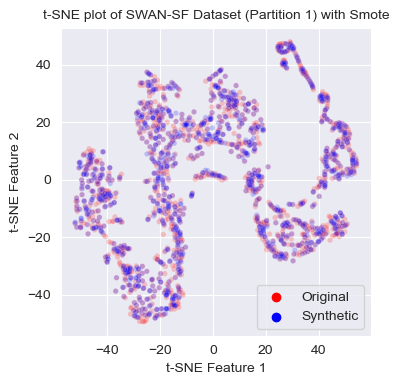

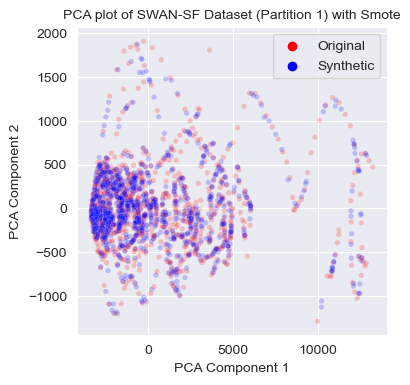


Discriminative Score (accuracy):
0.48339973439575035




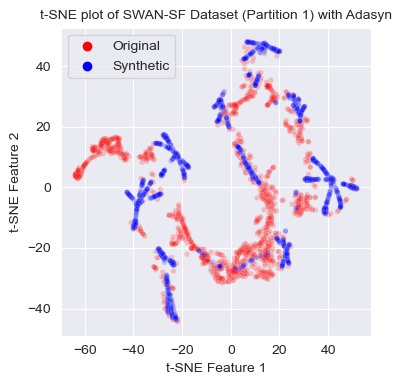

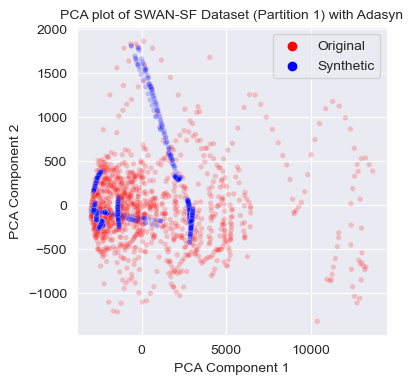


Discriminative Score (accuracy):
0.7237715803452855


Partition2: 
(146736, 1440)
(146736,)
(146679, 1440)
(146679,)



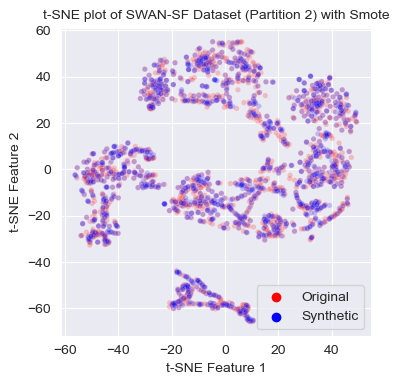

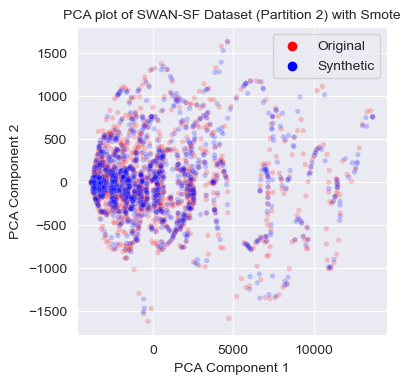


Discriminative Score (accuracy):
0.4577883472057075




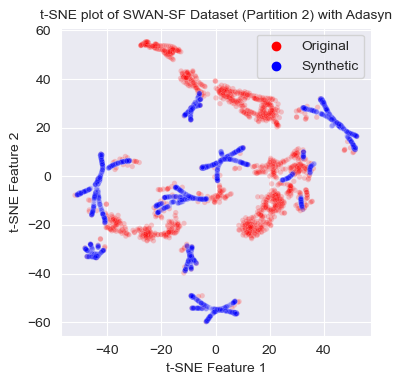

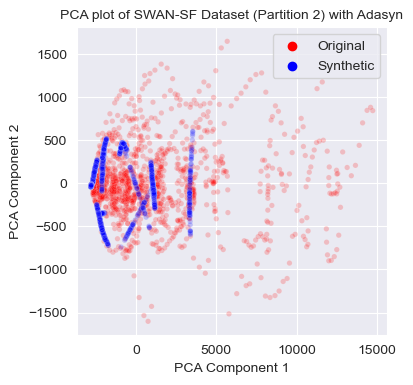


Discriminative Score (accuracy):
0.8133174791914387


Partition3: 
(69524, 1440)
(69524,)
(69422, 1440)
(69422,)



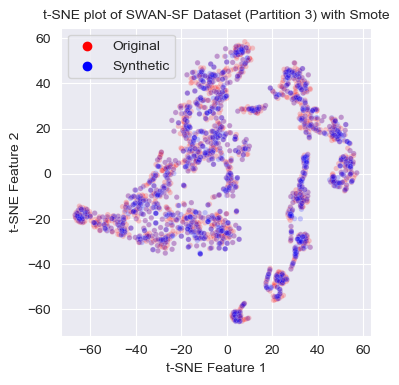

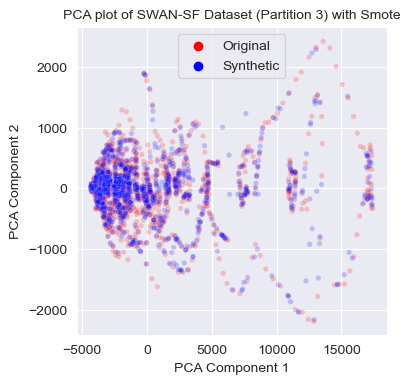


Discriminative Score (accuracy):
0.4994152046783626




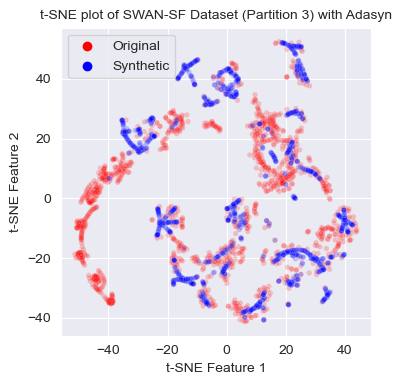

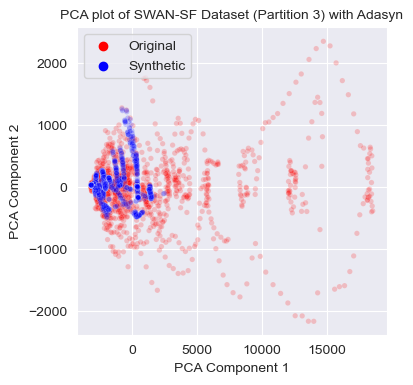


Discriminative Score (accuracy):
0.6467836257309941


Partition4: 
(86588, 1440)
(86588,)
(86631, 1440)
(86631,)



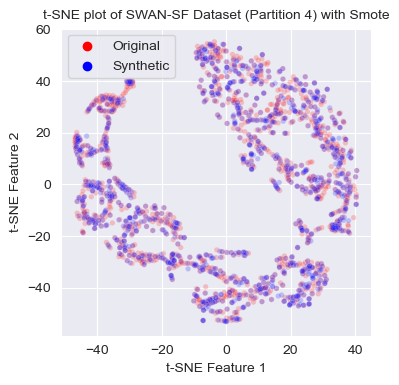

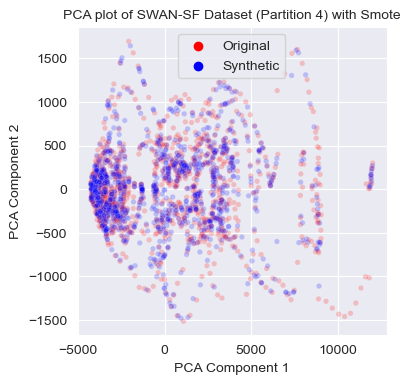


Discriminative Score (accuracy):
0.5150214592274678




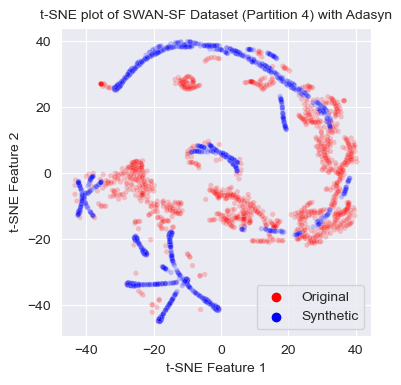

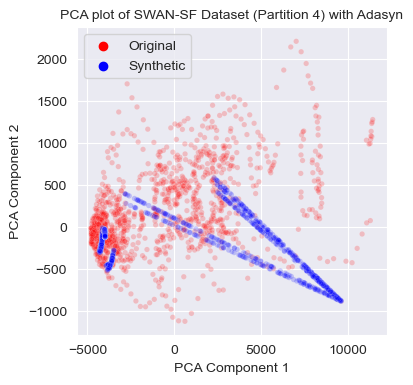


Discriminative Score (accuracy):
0.7453505007153076


Partition5: 
(125376, 1440)
(125376,)
(125340, 1440)
(125340,)



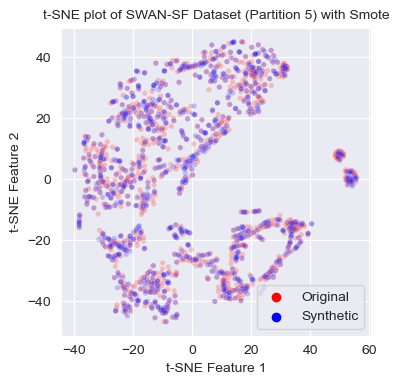

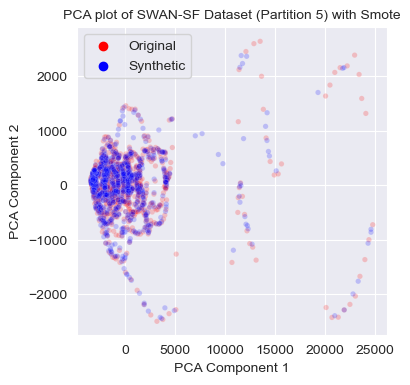


Discriminative Score (accuracy):
0.5




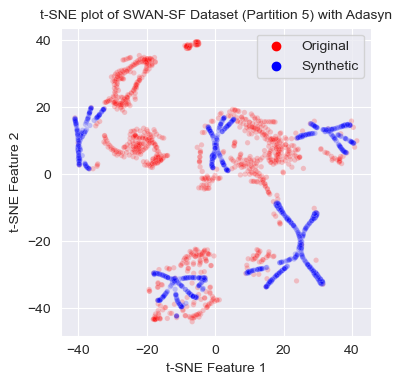

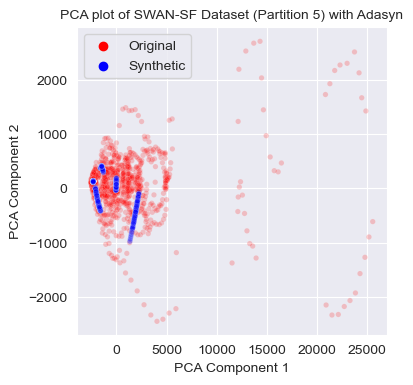


Discriminative Score (accuracy):
0.734006734006734




In [11]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutB&C_Concatenation_KnnImputation"

smote_adasyn(1, 5, data_dir, name, X_train_array, Y_train_array)

### GNI

Partition1: 
(120260, 1440)
(120260,)



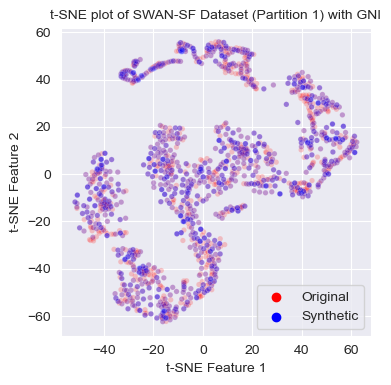

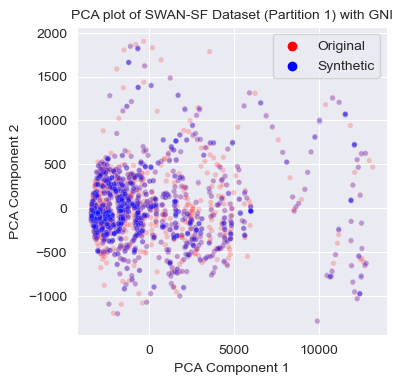


Discriminative Score (accuracy):
0.4820717131474104


Partition2: 
(146736, 1440)
(146736,)



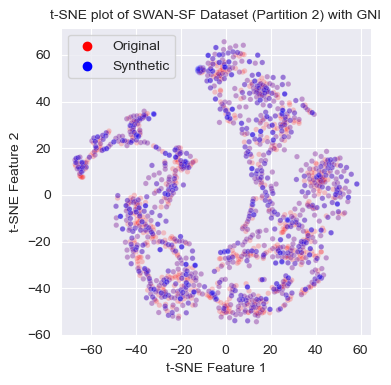

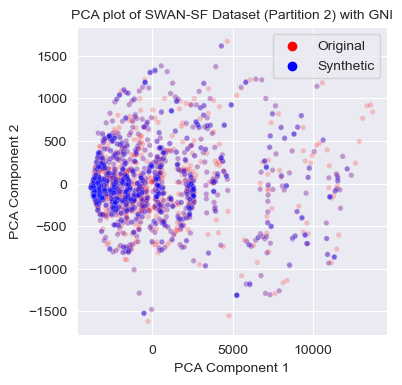


Discriminative Score (accuracy):
0.4994054696789536


Partition3: 
(69524, 1440)
(69524,)



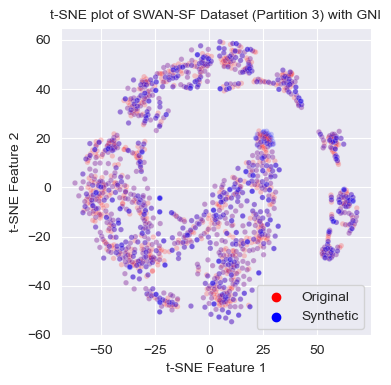

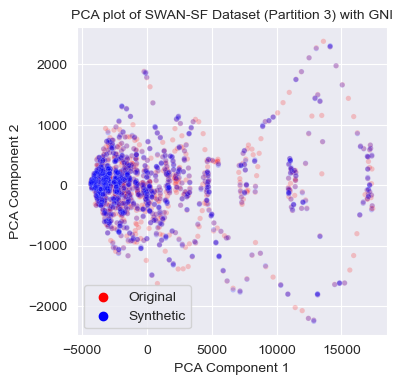


Discriminative Score (accuracy):
0.4853801169590643


Partition4: 
(86588, 1440)
(86588,)



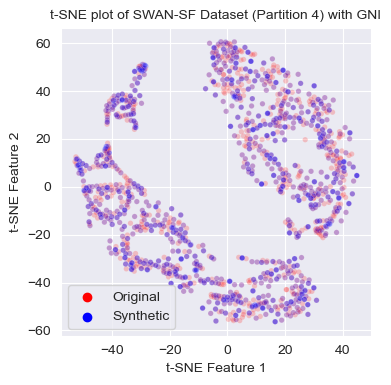

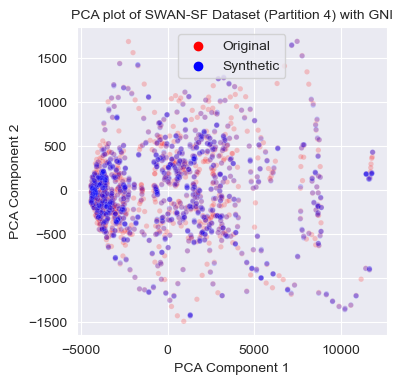


Discriminative Score (accuracy):
0.5092989985693849


Partition5: 
(125376, 1440)
(125376,)



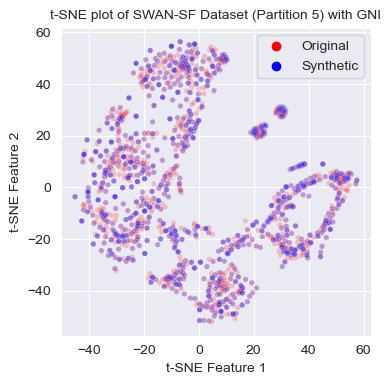

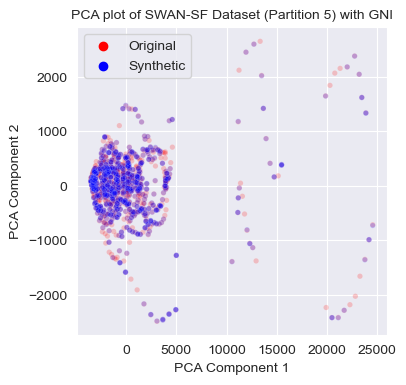


Discriminative Score (accuracy):
0.4781144781144781




In [12]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutB&C_Concatenation_KnnImputation"

gni(1, 5, data_dir, name, X_train_array, Y_train_array)

## 2D to 3D

In [8]:
num_attributes = 24
num_partitions = 5
num_timestamps = 60
X_train_concat_ZM_3D = []
for i in range(0, num_partitions):
    new_3D = np.zeros((X_train_array[i].shape[0], num_timestamps, num_attributes))

    for j in range(0, X_train_array[i].shape[0]):
        for m in range(0, num_attributes):
            new_3D[j,:,m] = X_train_array[i][j,m*num_timestamps:(m+1)*num_timestamps]
    X_train_concat_ZM_3D.append(new_3D)

In [9]:
del X_train_array

### TimeGAN

Start Embedding Network Training
step: 0/8000, e_loss: 0.24
step: 1000/8000, e_loss: 0.0718
step: 2000/8000, e_loss: 0.0536
step: 3000/8000, e_loss: 0.042
step: 4000/8000, e_loss: 0.0333
step: 5000/8000, e_loss: 0.0294
step: 6000/8000, e_loss: 0.027
step: 7000/8000, e_loss: 0.0238
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.2741
step: 1000/8000, s_loss: 0.026
step: 2000/8000, s_loss: 0.0167
step: 3000/8000, s_loss: 0.0142
step: 4000/8000, s_loss: 0.0122
step: 5000/8000, s_loss: 0.011
step: 6000/8000, s_loss: 0.0112
step: 7000/8000, s_loss: 0.0098
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 2.4854, g_loss_u: 0.4832, g_loss_s: 0.0164, g_loss_v: 0.3502, e_loss_t0: 0.0668
step: 1000/8000, d_loss: 0.766, g_loss_u: 2.7045, g_loss_s: 0.0153, g_loss_v: 0.0492, e_loss_t0: 0.0212
step: 2000/8000, d_loss: 1.5831, g_loss_u: 2.6853, g_loss_s: 0.0205, g_loss_v: 0.054, e_loss_t0: 0.0189
step: 3000/8000, d_

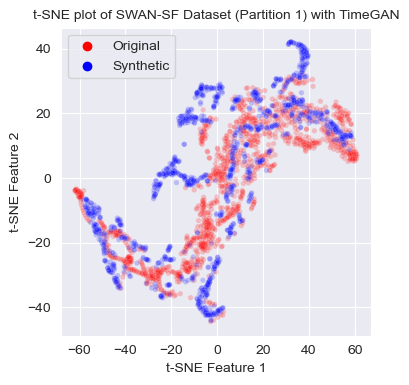

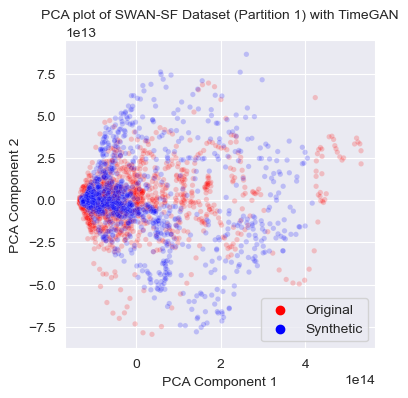


Discriminative Score (accuracy):
0.7755644090305445


Partition1: 
(119068, 1440)
(119068,)

Start Embedding Network Training
step: 0/8000, e_loss: 0.2786
step: 1000/8000, e_loss: 0.0711
step: 2000/8000, e_loss: 0.0428
step: 3000/8000, e_loss: 0.0309
step: 4000/8000, e_loss: 0.0271
step: 5000/8000, e_loss: 0.0227
step: 6000/8000, e_loss: 0.0198
step: 7000/8000, e_loss: 0.0186
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.2484
step: 1000/8000, s_loss: 0.027
step: 2000/8000, s_loss: 0.0175
step: 3000/8000, s_loss: 0.0157
step: 4000/8000, s_loss: 0.0132
step: 5000/8000, s_loss: 0.0116
step: 6000/8000, s_loss: 0.0111
step: 7000/8000, s_loss: 0.0104
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 1.9291, g_loss_u: 0.9501, g_loss_s: 0.0201, g_loss_v: 0.2279, e_loss_t0: 0.0474
step: 1000/8000, d_loss: 0.871, g_loss_u: 2.2442, g_loss_s: 0.0223, g_loss_v: 0.0346, e_loss_t0: 0.0152
step: 2000/8000, d_loss:

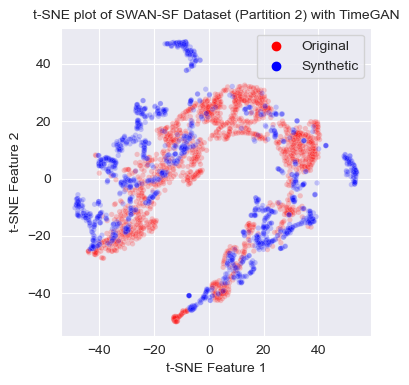

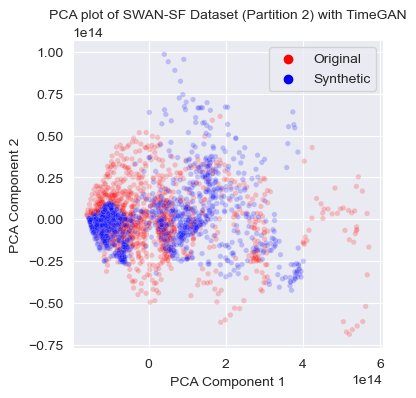


Discriminative Score (accuracy):
0.7883472057074911


Partition2: 
(146220, 1440)
(146220,)

Start Embedding Network Training
step: 0/8000, e_loss: 0.2504
step: 1000/8000, e_loss: 0.0508
step: 2000/8000, e_loss: 0.0364
step: 3000/8000, e_loss: 0.0312
step: 4000/8000, e_loss: 0.0288
step: 5000/8000, e_loss: 0.0262
step: 6000/8000, e_loss: 0.0248
step: 7000/8000, e_loss: 0.0241
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.2455
step: 1000/8000, s_loss: 0.0235
step: 2000/8000, s_loss: 0.018
step: 3000/8000, s_loss: 0.0143
step: 4000/8000, s_loss: 0.0132
step: 5000/8000, s_loss: 0.0119
step: 6000/8000, s_loss: 0.0101
step: 7000/8000, s_loss: 0.0109
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 2.0055, g_loss_u: 0.7259, g_loss_s: 0.0228, g_loss_v: 0.2731, e_loss_t0: 0.0565
step: 1000/8000, d_loss: 1.0295, g_loss_u: 2.2178, g_loss_s: 0.0216, g_loss_v: 0.0533, e_loss_t0: 0.0212
step: 2000/8000, d_loss

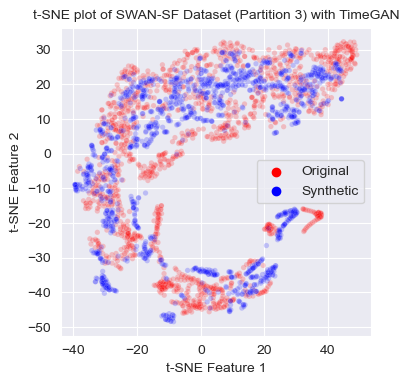

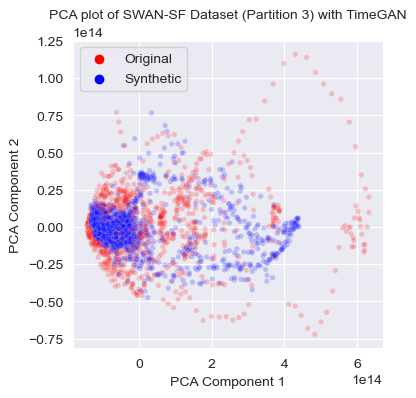


Discriminative Score (accuracy):
0.6596491228070176


Partition3: 
(68938, 1440)
(68938,)

Start Embedding Network Training
step: 0/8000, e_loss: 0.2701
step: 1000/8000, e_loss: 0.0578
step: 2000/8000, e_loss: 0.0344
step: 3000/8000, e_loss: 0.0268
step: 4000/8000, e_loss: 0.0246
step: 5000/8000, e_loss: 0.0222
step: 6000/8000, e_loss: 0.0209
step: 7000/8000, e_loss: 0.0199
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.2265
step: 1000/8000, s_loss: 0.0251
step: 2000/8000, s_loss: 0.0169
step: 3000/8000, s_loss: 0.0155
step: 4000/8000, s_loss: 0.016
step: 5000/8000, s_loss: 0.0139
step: 6000/8000, s_loss: 0.0129
step: 7000/8000, s_loss: 0.0105
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 2.458, g_loss_u: 0.5031, g_loss_s: 0.0197, g_loss_v: 0.2914, e_loss_t0: 0.0715
step: 1000/8000, d_loss: 0.9917, g_loss_u: 2.0337, g_loss_s: 0.0259, g_loss_v: 0.0579, e_loss_t0: 0.0168
step: 2000/8000, d_loss: 0

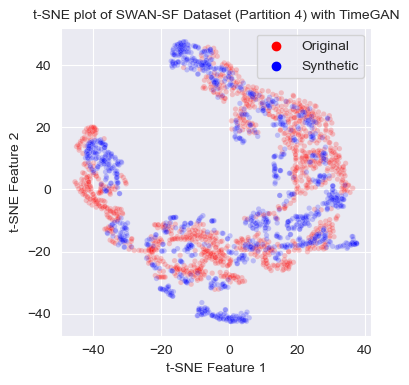

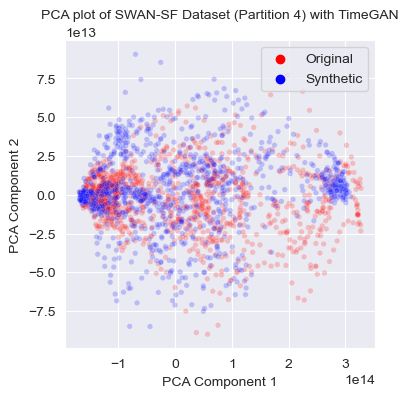


Discriminative Score (accuracy):
0.7796852646638054


Partition4: 
(86399, 1440)
(86399,)

Start Embedding Network Training
step: 0/8000, e_loss: 0.2643
step: 1000/8000, e_loss: 0.0417
step: 2000/8000, e_loss: 0.0295
step: 3000/8000, e_loss: 0.0255
step: 4000/8000, e_loss: 0.0225
step: 5000/8000, e_loss: 0.0222
step: 6000/8000, e_loss: 0.0208
step: 7000/8000, e_loss: 0.02
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, s_loss: 0.2644
step: 1000/8000, s_loss: 0.0215
step: 2000/8000, s_loss: 0.0151
step: 3000/8000, s_loss: 0.0139
step: 4000/8000, s_loss: 0.0109
step: 5000/8000, s_loss: 0.0096
step: 6000/8000, s_loss: 0.0105
step: 7000/8000, s_loss: 0.0086
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, d_loss: 1.9745, g_loss_u: 0.7194, g_loss_s: 0.0201, g_loss_v: 0.28, e_loss_t0: 0.0591
step: 1000/8000, d_loss: 0.7172, g_loss_u: 2.0627, g_loss_s: 0.0212, g_loss_v: 0.0693, e_loss_t0: 0.018
step: 2000/8000, d_loss: 0.93

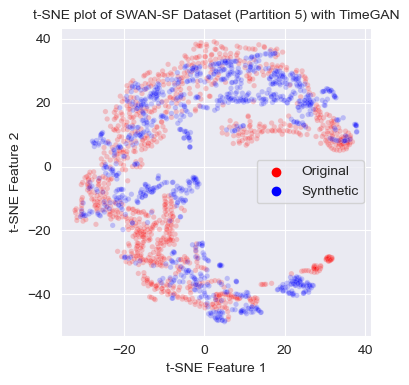

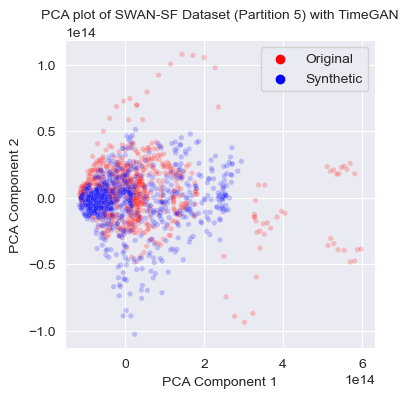


Discriminative Score (accuracy):
0.7777777777777778


Partition5: 
(125058, 1440)
(125058,)



In [10]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutB&C_Concatenation_KnnImputation"

timegan_oversamping(1, 5, data_dir, name, X_train_concat_ZM_3D, Y_train_array)